<a href="https://colab.research.google.com/github/ansiyo/Machine-Learning-Rep/blob/main/SoilCarbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

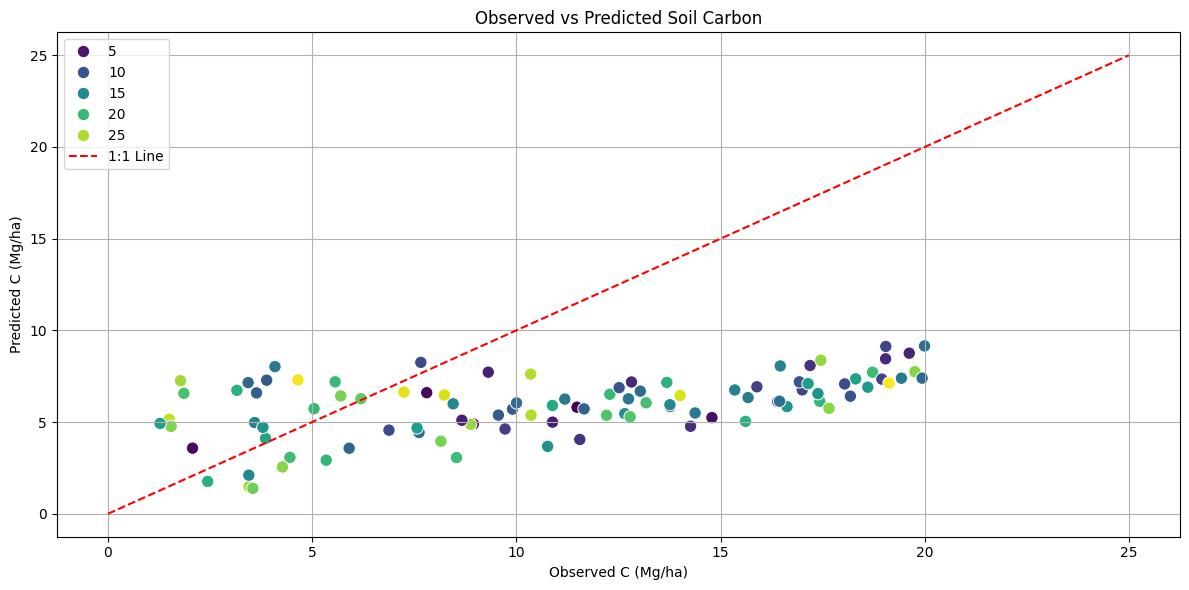

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate loading the dataset (since we don't have the actual CSV, we create a mock version)
np.random.seed(42)
n = 100

df = pd.DataFrame({
    'Site': [f"Site_{i}" for i in range(n)],
    'Upper_Depth': np.random.uniform(0, 10, size=n),
    'Lower_Depth': np.random.uniform(10, 30, size=n),
    'Compost': np.random.uniform(0, 1000, size=n),
    'POXc': np.random.uniform(0.1, 10, size=n),
    'MBC': np.random.uniform(0.1, 5, size=n),
    'C_Mg_ha': np.random.uniform(1, 20, size=n),
})

# 1. Calculate profile depth
df['Depth_cm'] = df['Lower_Depth'] - df['Upper_Depth']

# 2. Estimate Carbon input from compost
df['Compost_C_Input'] = df['Compost'] * 0.25 / 1000  # convert to Mg C

# 3. Partition SOC into pools
df['Fast_SOC'] = df['POXc']
df['Slow_SOC'] = df['MBC']
df['Passive_SOC'] = df['C_Mg_ha'] - (df['Fast_SOC'] + df['Slow_SOC'])

# Ensure no negative values in Passive_SOC
df['Passive_SOC'] = df['Passive_SOC'].clip(lower=0)

# 4. Predict total C using a simplified linear model
# Assume predicted C is a function of compost input and active SOC pools
df['Predicted_C_Mg_ha'] = 0.8 * df['Compost_C_Input'] + 0.5 * df['Fast_SOC'] + 0.7 * df['Slow_SOC'] + 0.3 * df['Passive_SOC']

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='C_Mg_ha', y='Predicted_C_Mg_ha', hue='Depth_cm', palette='viridis', s=80)
plt.plot([0, 25], [0, 25], 'r--', label='1:1 Line')
plt.xlabel('Observed C (Mg/ha)')
plt.ylabel('Predicted C (Mg/ha)')
plt.title('Observed vs Predicted Soil Carbon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

Data Infrastructure

In [ ]:
def load_and_preprocess(filepath):
    """Load and preprocess the dataset."""
    df = pd.read_csv(filepath)

    # Handle missing values (example: drop rows with missing SOC data)
    df = df.dropna(subset=['per_C', 'C_Mg_ha', 'BD', 'pH', 'EOC'])

    # Convert categorical variables (e.g., one-hot encoding)
    df = pd.get_dummies(df, columns=['Soil_Type', 'Treatment', 'Crops'], drop_first=True)

    # Calculate derived metrics (if needed)
    df['silt_clay_ratio'] = df['silt'] / (df['clay'] + 1e-6)  # Avoid division by zero

    return df

Carbon Input Estimation

In [ ]:
def train_carbon_model(df, target_var='C_Mg_ha'):
    """Train a model to estimate SOC based on management practices."""
    # Features: Management + Soil Properties
    features = [
        'Compost', 'Cover_Crop', 'HR_age', 'BD', 'pH', 'clay',
        'silt_clay_ratio', 'EOC', 'MBC'
    ]

    # Ensure features exist in the dataframe
    features = [f for f in features if f in df.columns]
    X = df[features]
    y = df[target_var]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Model Performance: RMSE = {rmse:.2f}, R² = {r2:.2f}")

    return model, features

Pool Calibration

In [ ]:
def estimate_carbon_pools(df):
    """Estimate fast, slow, and passive SOC pools."""
    # Hypothetical partitioning (adjust based on literature)
    df['fast_pool'] = df['EOC'] * 0.75  # Labile carbon (EOC as proxy)
    df['slow_pool'] = (df['per_C'] - df['fast_pool']) * 0.5  # Intermediate
    df['passive_pool'] = df['per_C'] - df['fast_pool'] - df['slow_pool']  # Mineral-associated

    # Validate pools sum to total SOC
    assert np.allclose(df['per_C'], df['fast_pool'] + df['slow_pool'] + df['passive_pool'], rtol=0.1)

    return df

Sensitivity Analysis

In [ ]:
def sensitivity_analysis(model, X, df):
    """Identify key drivers of SOC using SHAP and permutation importance."""
    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")

    # Permutation importance
    result = permutation_importance(model, X, df['C_Mg_ha'], n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)

    print("\nPermutation Importance:")
    print(importance_df)

    return importance_df

Data preprocessing complete. Shape: (240, 53)
Model Performance: RMSE = 9.53, R² = 0.34

Carbon pool estimates:
        fast_pool   slow_pool  passive_pool
count  240.000000  240.000000    240.000000
mean    22.629283  -10.570024    -10.570024
std     18.780376    9.299268      9.299268
min      7.926217  -97.532457    -97.532457
25%     13.277427  -11.219715    -11.219715
50%     17.936308   -8.119054     -8.119054
75%     24.300000   -5.949973     -5.949973
max    195.634250   -3.326522     -3.326522


<ipython-input-10-74f922eccb49>:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar")


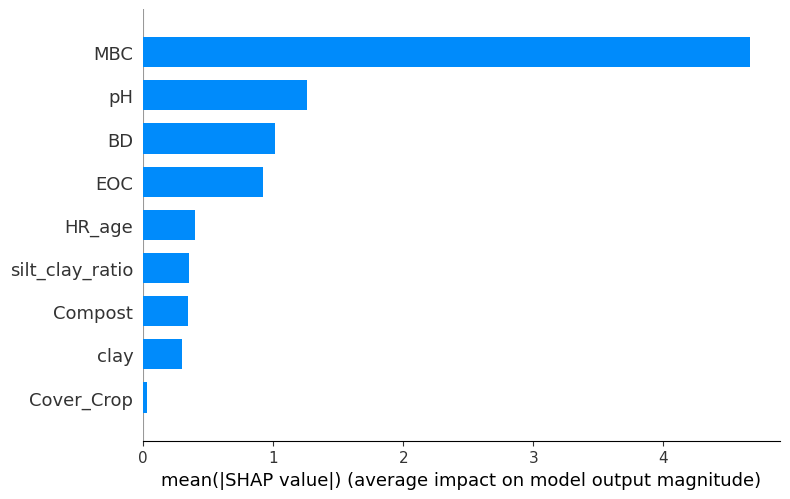


Permutation Importance:
           feature  importance
8              MBC    0.724436
4               pH    0.173815
3               BD    0.140918
7              EOC    0.123371
2           HR_age    0.043519
0          Compost    0.037418
6  silt_clay_ratio    0.036835
5             clay    0.031752
1       Cover_Crop    0.001603


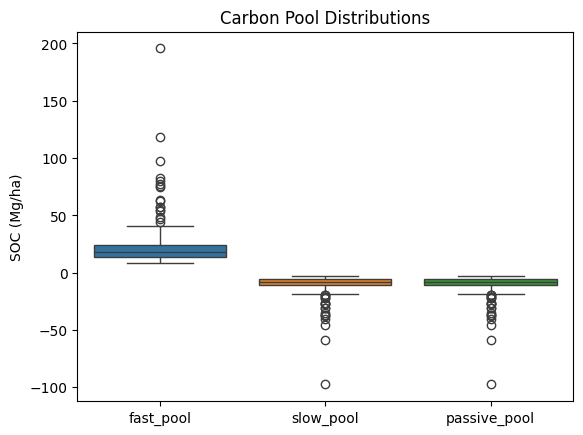

In [ ]:
if __name__ == "__main__":
    # Step 1: Load and preprocess data
    df = load_and_preprocess("/content/HR_Soil_Health_Updated.csv")
    print("Data preprocessing complete. Shape:", df.shape)

    # Step 2: Train carbon model
    model, features = train_carbon_model(df)

    # Step 3: Estimate carbon pools
    df = estimate_carbon_pools(df)
    print("\nCarbon pool estimates:")
    print(df[['fast_pool', 'slow_pool', 'passive_pool']].describe())

    # Step 4: Sensitivity analysis
    X = df[features]
    importance_df = sensitivity_analysis(model, X, df)

    # Optional: Plot pool distributions
    sns.boxplot(data=df[['fast_pool', 'slow_pool', 'passive_pool']])
    plt.title("Carbon Pool Distributions")
    plt.ylabel("SOC (Mg/ha)")
    plt.show()